In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer

In [2]:
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r = np.sqrt(x**2 + y**2)
    az = np.degrees(np.arctan2(x, y))
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az


def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y


def UTM2Island(eutm, nutm, eoff=383520.0, noff=3860830.0, rot=42.0):
    """
    Convert UTM NAD83 Zone 18N easting, northing to N. Core Banks alongshore, cross-shore coordinates
    xisl, yisl = UTM2Island( eutm, nutm )
    Better to use values from the dict than defaults for translation/rotation values
    Defaults are associated with the dict read in from `small_island_box.yml`
    """
    [r, az] = pcoord(eutm-eoff, nutm-noff)
    az = az + rot
    [xisl,yisl] = xycoord(r,az)
    return xisl, yisl


def island2UTM(alongshore, across_shore, eoff=383520.0, noff=3860830.0, rot=42.):
    """Convert island coordinates to UTM
       Inverse of UTM2Island()
       Better to use values from the dict than defaults for translation/rotation values
       Defaults are associated with the dict read in from `small_island_box.yml`
       Here is code for UTM2island:
          [r, az] = pcoord(eutm-eoff, nutm-noff)
          az = az + rot
          [xisl,yisl] = xycoord(r,az)
    """
    r, az = pcoord(alongshore, across_shore)
    az = az - rot
    eUTM, nUTM = xycoord(r, az)
    eUTM = eUTM + eoff
    nUTM = nUTM + noff
    return eUTM, nUTM


In [3]:
# load grid info...dont actually need this file.
# /vortexfs1/share/usgs-share/Projects/grids/NCoreBanks_sub9_chrisbathy_long3.grd

In [13]:
url_CSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/dorian_his.ncml'
url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
url_FSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/dorian_his.ncml'
url_FSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/dorian_his.ncml'
#url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
ds_CSYV = xr.open_dataset(url_CSYV)
ds_CSYV

<xarray.Dataset>
Dimensions:                 (tracer: 4, NST: 3, s_rho: 8, s_w: 9,
                             eta_rho: 1057, xi_rho: 1317, eta_u: 1057,
                             xi_u: 1316, eta_v: 1056, xi_v: 1317,
                             eta_psi: 1056, xi_psi: 1316, ocean_time: 37,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 -0.9375 -0.8125 ... -0.1875 -0.0625
  * s_w                     (s_w) float64 -1.0 -0.875 -0.75 ... -0.25 -0.125 0.0
    lon_rho                 (eta_rho, xi_rho) float64 ...
    lat_rho                 (eta_rho, xi_rho) float64 ...
    lon_u                   (eta_u, xi_u) float64 ...
    lat_u                   (eta_u, xi_u) float64 ...
    lon_v                   (eta_v, xi_v) float64 ...
    lat_v                   (eta_v, xi_v) float64 ...
    lon_psi                 (eta_psi, xi_psi) float64 ...
    lat_psi                 (eta_psi, xi_psi) float64 ...
  * ocean_time              (ocean_time) datetime64[ns] 2019-09-06T10:15:00.0...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/182)
    ntimes                  int32 ...
    ndtfast                 int32 ...
    dt                      float64 ...
    dtfast                  float64 ...
    dstart                  datetime64[ns] ...
    nHIS                    int32 ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00019.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  varinfo.dat
    ...                        ...
    tiling:                    015x012
    history:                   ROMS/TOMS, Version 3.9, Saturday - October 15,...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         8
    EXTRA_DIMENSION.boundary:  4

In [14]:
lon = np.squeeze( ds_CSYV.lon_rho.load().values )
lat = np.squeeze( ds_CSYV.lat_rho.load().values )

In [15]:
# Conver lat/lon to UTM zone 18N, and then to island coordinates
transformer = Transformer.from_crs( 'epsg:4326', 'epsg:26918',  ) # WGS84 to UTM18
print(lat.shape)
utmx, utmy = transformer.transform( lat, lon )
print(utmx.shape)
xisl, yisl = UTM2Island(utmx, utmy, eoff=383520.0, noff=3860830.0, rot=42.0)
print(xisl.shape)

(1057, 1317)
(1057, 1317)
(1057, 1317)


In [16]:
t=ds_CSYV.ocean_time.load()
tstring = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M')
tstring

Index(['2019-09-06 10:15', '2019-09-06 10:30', '2019-09-06 10:45',
       '2019-09-06 11:00', '2019-09-06 11:15', '2019-09-06 11:30',
       '2019-09-06 11:45', '2019-09-06 12:00', '2019-09-06 12:15',
       '2019-09-06 12:30', '2019-09-06 12:45', '2019-09-06 13:00',
       '2019-09-06 13:14', '2019-09-06 13:29', '2019-09-06 13:44',
       '2019-09-06 13:59', '2019-09-06 14:14', '2019-09-06 14:29',
       '2019-09-06 14:45', '2019-09-06 15:00', '2019-09-06 15:15',
       '2019-09-06 15:30', '2019-09-06 15:45', '2019-09-06 16:00',
       '2019-09-06 16:15', '2019-09-06 16:30', '2019-09-06 16:45',
       '2019-09-06 17:00', '2019-09-06 17:15', '2019-09-06 17:30',
       '2019-09-06 17:45', '2019-09-06 18:00', '2019-09-06 18:15',
       '2019-09-06 18:30', '2019-09-06 18:45', '2019-09-06 19:00',
       '2019-09-06 19:15'],
      dtype='object')

In [116]:
print(tstring[19])
print(tstring[31])

2019-09-06 15:00
2019-09-06 18:00


In [17]:
# load initial and final bathymetry
bathi = ds_CSYV.bath[0,:,:].load()
bathf = ds_CSYV.bath[-1,:,:].load()

Contour intervals:  [-1  0  1  2  3]


/tmp/ipykernel_64117/2508538853.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0 = ax0.pcolormesh(xisl,yisl,-bathi,cmap='terrain',vmin=-2,vmax=5)


Text(0.35, 0.9, 'Smoothed')

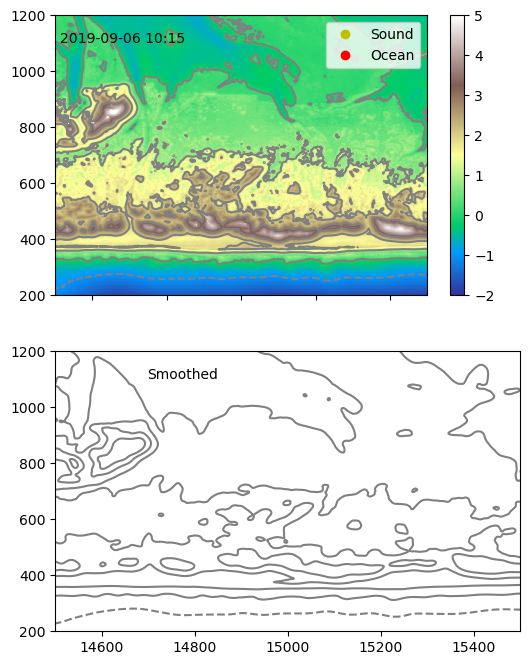

In [19]:
# smooth bathy
from scipy.ndimage import convolve
# experimenting with size of kernal suggest 15 is ok
ik = 15
k = np.ones((ik, ik)) / (ik*ik)
bathis = convolve(bathi,k,mode='nearest')

# define contour intervals
cl = np.arange(-1,4,1)
print('Contour intervals: ',cl)

xs = 14500
xe = 15500
ys = 200
ye = 1200
fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,8),sharex=True)
m0 = ax0.pcolormesh(xisl,yisl,-bathi,cmap='terrain',vmin=-2,vmax=5)
m0c = ax0.contour(xisl,yisl,-bathi,cl,colors='gray',vmin=-2,vmax=5)
plt.colorbar(m0, ax=ax0)
ax0.plot(650,750,'oy',label='Sound')
ax0.plot(650,50,'or',label='Ocean')
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.text(0.35, 0.9, '{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')
ax0.legend()
#m1 = ax1.pcolormesh(y,x,-bathis,cmap='terrain',vmin=-2,vmax=5)
m1c = ax1.contour(xisl,yisl,-bathis,cl,colors='gray',vmin=-2,vmax=5)
#plt.colorbar(m1, ax=ax1)
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.text(0.35, 0.9, 'Smoothed', transform=ax1.transAxes, ha='right')

In [21]:
ys, xs = 750,650
yo, xo = 50, 650
zs = ds_CSYV.zeta[:,ys,xs].load()
zo = ds_CSYV.zeta[:,yo,xo].load()

Sound zmax: 2.7950313091278076 at 2019-09-06T12:45:00.075094016
Diff max: 2.8085360527038574 at 2019-09-06T13:00:00.078527488
izsmax =  10 izdmax =  11


Text(0, 0.5, 'Difference (m)')

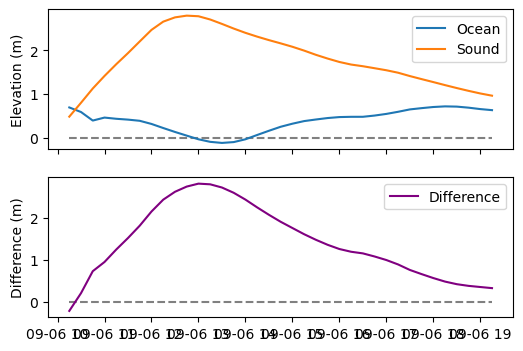

In [22]:
izsmax = np.argmax(zs.values)
tzsmax = t.values[izsmax]
zsmax = zs.values[izsmax]
print('Sound zmax: {} at {}'.format(zsmax, tzsmax) )

zdiff = zs.values - zo.values
izdmax = np.argmax(zdiff)
tdmax = t.values[izdmax]
zdmax = zdiff[izdmax]
print('Diff max: {} at {}'.format(zdmax, tdmax) )
print('izsmax = ', izsmax, 'izdmax = ', izdmax) 

fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,4),sharex=True)
ax0.plot(t,np.zeros_like(zo),'--',c='gray')
ax0.plot(t,zo,label='Ocean')
ax0.plot(t,zs,label='Sound')
ax0.set_ylabel('Elevation (m)')
ax0.legend()

ax1.plot(t,np.zeros_like(zo),'--',c='gray')
ax1.plot(t,zs-zo,c='purple',label='Difference')
ax1.legend()
ax1.set_ylabel('Difference (m)')

/tmp/ipykernel_64117/1753046619.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0 = ax0.pcolormesh(xisl,yisl,-bathi,cmap='terrain',vmin=-2,vmax=5)
/tmp/ipykernel_64117/1753046619.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m1 = ax1.pcolormesh(xisl,yisl,-bathf,cmap='terrain',vmin=-2,vmax=5)


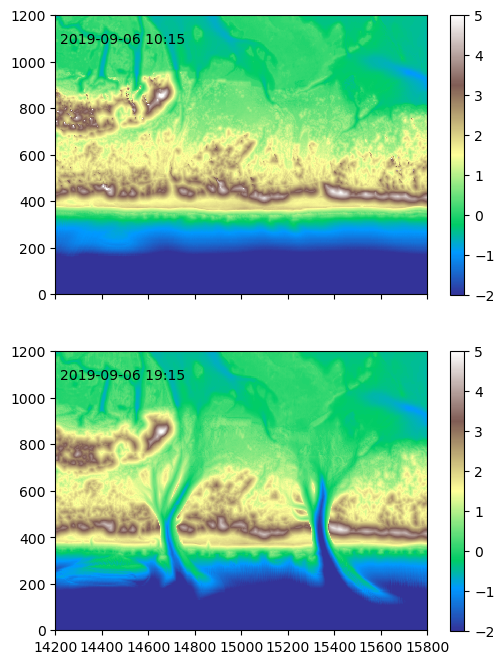

In [23]:
# Look at before/after bathy
xs = 14200
xe = 15800
ys = 0
ye = 1200

fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,8),sharex=True)
m0 = ax0.pcolormesh(xisl,yisl,-bathi,cmap='terrain',vmin=-2,vmax=5)
plt.colorbar(m0, ax=ax0)
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.set_aspect('equal')
ax0.text(0.35, 0.9, '{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')
m1 = ax1.pcolormesh(xisl,yisl,-bathf,cmap='terrain',vmin=-2,vmax=5)
plt.colorbar(m1, ax=ax1)
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.set_aspect('equal')
ax1.text(0.35, 0.9, '{}'.format(tstring[-1]), transform=ax1.transAxes, ha='right')
fig.savefig('init_final_bathy.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_64117/1502076107.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0 = ax0.pcolormesh(xisl,yisl,bdiff,cmap='seismic_r',vmin=-3,vmax=3)


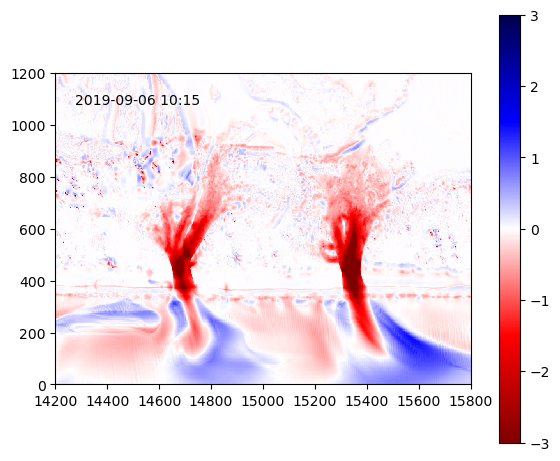

In [24]:
bdiff = -(bathf - bathi)
fig, ax0  = plt.subplots(1,1,figsize=(6,8),sharex=True)
m0 = ax0.pcolormesh(xisl,yisl,bdiff,cmap='seismic_r',vmin=-3,vmax=3)
plt.colorbar(m0, ax=ax0, fraction=0.046, pad=0.06)
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.set_aspect('equal')
ax0.text(0.35, 0.9, '{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')
fig.savefig('final_minus_initial_bathy.png', dpi=200, bbox_inches='tight')

In [ ]:
# do some statistics on the erosion
xs = 14200
xe = 15800
ys = 0
ye = 400
print( np.argmin(xislxs) )
np.shape(bdiff)


In [ ]:
yisl[215]

In [ ]:
xisl[0]

In [73]:
# contour intervals
cl = np.arange(-1,4,1)
# time indices
ti = [0, 10, 31]
for i in ti:
    print(t.values[i])

2019-09-06T10:15:00.040762368
2019-09-06T12:45:00.075094016
2019-09-06T18:00:00.047192064


In [74]:
def mask_array( x, wdm ):
    s = wdm.shape
    wdmr = np.ravel(wdm)
    xr = np.ravel(x)
    xr[np.where(wdmr==0)]=np.nan
    xm = np.reshape( xr, s )
    return xm

def despeckle( x, iks = 3 ):
    # despeckle like this? This expands the NaN regions with a 3x3 matrix
    ks = np.ones((iks, iks)) / (iks*iks)
    xs = convolve(x,ks,mode='nearest')
    return xs

In [121]:
np.arange(0, len(tstring), 2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36])

xisl: (1057, 1317)
yisl: (1057, 1317)
u: (1057, 1316)
v: (1056, 1317)
uc: (1056, 1316)
vc: (1056, 1316)
spd: (1056, 1316)
xd: (53, 66)
yd: (53, 66)
ud: (53, 66)
vd: (53, 66)


/tmp/ipykernel_64117/788467615.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m1 = ax1.pcolormesh(xisl, yisl, zeta, cmap='YlGnBu_r',vmin=0, vmax=2.5, alpha = .6, zorder=1)
/tmp/ipykernel_64117/788467615.py:74: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m2 = ax2.pcolormesh(xisl, yisl, hwave, cmap='coolwarm',vmin=0, vmax=3, alpha = .6, zorder=1)


xisl: (1057, 1317)
yisl: (1057, 1317)
u: (1057, 1316)
v: (1056, 1317)
uc: (1056, 1316)
vc: (1056, 1316)
spd: (1056, 1316)
xd: (53, 66)
yd: (53, 66)
ud: (53, 66)
vd: (53, 66)
xisl: (1057, 1317)
yisl: (1057, 1317)
u: (1057, 1316)
v: (1056, 1317)
uc: (1056, 1316)
vc: (1056, 1316)
spd: (1056, 1316)
xd: (53, 66)
yd: (53, 66)
ud: (53, 66)
vd: (53, 66)
xisl: (1057, 1317)
yisl: (1057, 1317)
u: (1057, 1316)
v: (1056, 1317)
uc: (1056, 1316)
vc: (1056, 1316)
spd: (1056, 1316)
xd: (53, 66)
yd: (53, 66)
ud: (53, 66)
vd: (53, 66)
xisl: (1057, 1317)
yisl: (1057, 1317)
u: (1057, 1316)
v: (1056, 1317)
uc: (1056, 1316)
vc: (1056, 1316)
spd: (1056, 1316)
xd: (53, 66)
yd: (53, 66)
ud: (53, 66)
vd: (53, 66)
xisl: (1057, 1317)
yisl: (1057, 1317)
u: (1057, 1316)
v: (1056, 1317)
uc: (1056, 1316)
vc: (1056, 1316)
spd: (1056, 1316)
xd: (53, 66)
yd: (53, 66)
ud: (53, 66)
vd: (53, 66)
xisl: (1057, 1317)
yisl: (1057, 1317)
u: (1057, 1316)
v: (1056, 1317)
uc: (1056, 1316)
vc: (1056, 1316)
spd: (1056, 1316)
xd: (53,

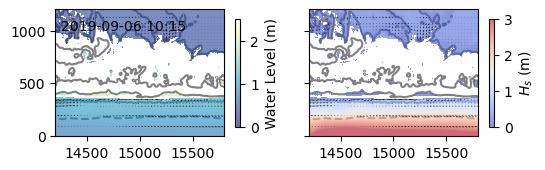

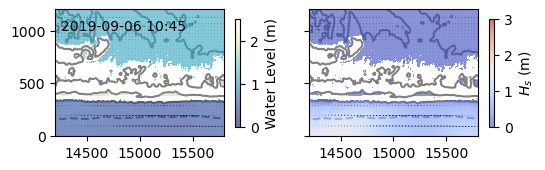

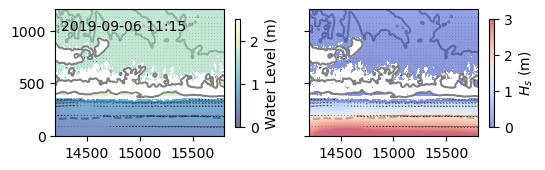

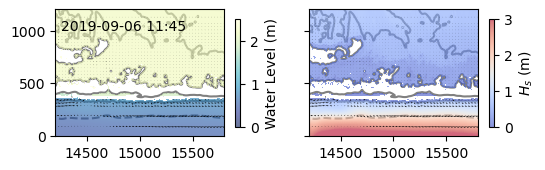

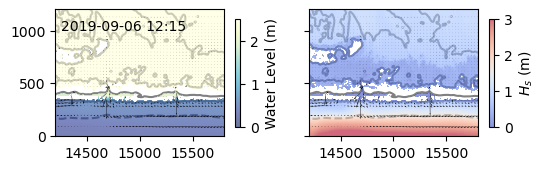

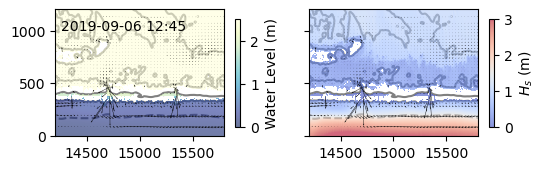

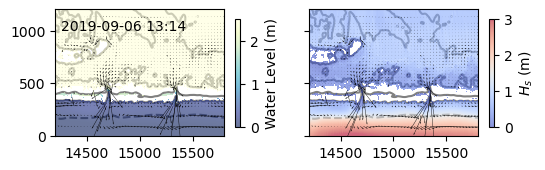

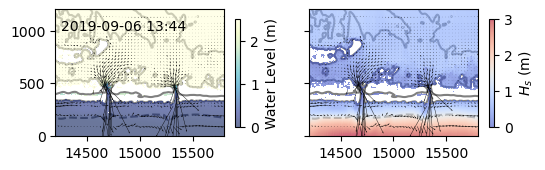

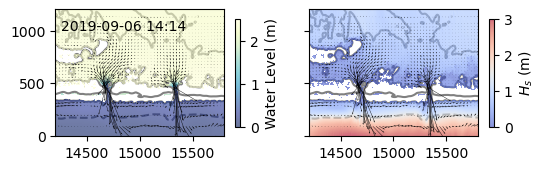

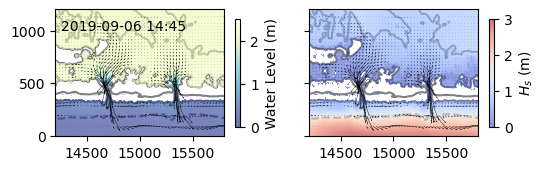

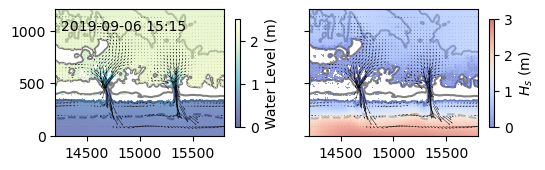

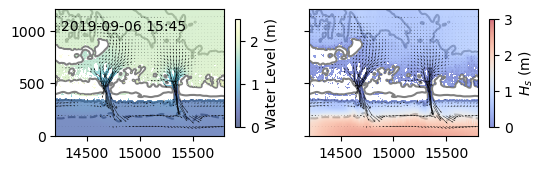

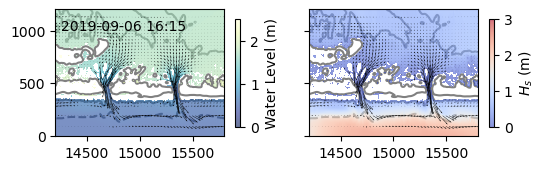

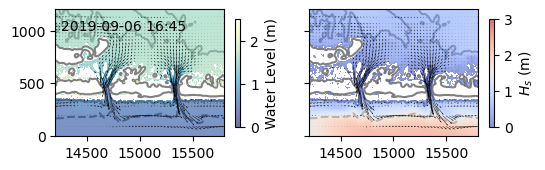

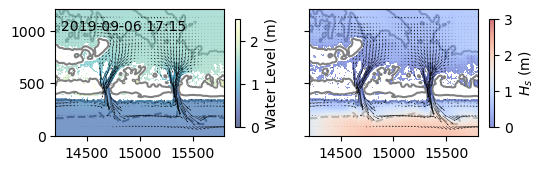

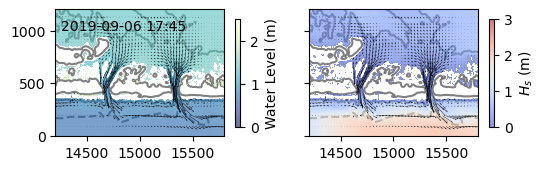

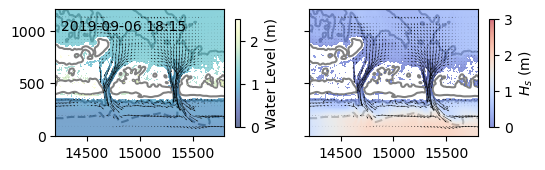

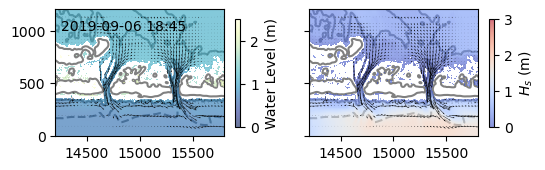

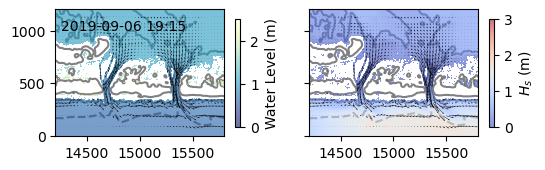

In [127]:
# pick a time index
# 0, 19, and 31

# idx = 31
for idx in np.arange(0, len(tstring), 2 ):

    # load bathy and smooth for contouring
    bath = np.squeeze( ds_CSYV.bath[idx,:,:].load().values )

    # define contour intervals
    cl = np.arange(-2,4,2)
    #print('Contour intervals: ',cl)
    ik = 15
    k = np.ones((ik, ik)) / (ik*ik)
    baths = convolve(bath,k,mode='nearest')

    # load water elevation and mask dry regions
    zeta = np.squeeze( ds_CSYV.zeta[idx,:,:].load().values )
    wdm = np.squeeze( ds_CSYV.wetdry_mask_rho[idx,:,:].load().values )
    zeta = despeckle( mask_array( zeta, wdm ) )

    # load wave height and mask dry regions
    hwave = np.squeeze( ds_CSYV.Hwave[idx,:,:].load().values )
    hwave = despeckle( mask_array( hwave, wdm ) )

    # load velocities
    u = despeckle( mask_array( np.squeeze( ds_CSYV.ubar[idx,:,:].load().values),
                              np.squeeze( ds_CSYV.wetdry_mask_u[idx,:,:].load().values) ) )
    v = despeckle( mask_array( np.squeeze( ds_CSYV.vbar[idx,:,:].load().values), 
                              np.squeeze( ds_CSYV.wetdry_mask_v[idx,:,:].load().values) ) )

    # print('xisl:',np.shape(xisl))
    # print('yisl:',np.shape(yisl))
    # print('u:',np.shape(u))
    # print('v:',np.shape(v))

    uc = 0.5 * (u[0:-1,:]+u[1:,:])
    vc = 0.5 * (v[:,0:-1]+v[:,1:])
    # print('uc:',np.shape(uc))
    # print('vc:',np.shape(vc))

    spd = np.sqrt( uc**2 + vc**2 )
    # print('spd:',np.shape(spd))

    # decimate velocities
    dfac = 20
    ud = uc[::dfac, ::dfac]
    vd = vc[::dfac, ::dfac]
    xd = xisl[::dfac, ::dfac]
    yd = yisl[::dfac, ::dfac]

    # print('xd:',np.shape(xd))
    # print('yd:',np.shape(yd))
    # print('ud:',np.shape(ud))
    # print('vd:',np.shape(vd))

    fig, [ax1, ax2]  = plt.subplots(1,2,figsize=(6, 14),sharey=True)

    m1c = ax1.contour(xisl,yisl,-baths,cl,colors='gray',vmin=-2,vmax=5, zorder=0)
    m1 = ax1.pcolormesh(xisl, yisl, zeta, cmap='YlGnBu_r',vmin=0, vmax=2.5, alpha = .6, zorder=1)
    ax1.quiver(xd, yd, ud, vd, color='black', alpha=1, zorder=2)
    #plt.colorbar(m1, ax=ax1, fraction=0.046, pad=0.06)
    cbar1 = plt.colorbar(m1, ax=ax1, shrink=.1)
    cbar1.set_label(r'Water Level (m)', rotation=90)

    ax1.set_xlim([xs, xe])
    ax1.set_ylim([ys, ye])
    ax1.set_aspect('equal')
    #ax1.text(0.85, 0.9, r'{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')
    ax1.text(14250, 1000, r'{}'.format(tstring[idx]), ha='left')

    m2c = ax2.contour(xisl,yisl,-baths,cl,colors='gray',vmin=-2,vmax=5, zorder=0)
    m2 = ax2.pcolormesh(xisl, yisl, hwave, cmap='coolwarm',vmin=0, vmax=3, alpha = .6, zorder=1)
    ax2.quiver(xd, yd, ud, vd, color='black', alpha=1, zorder=2)
    #plt.colorbar(m2, ax=ax2, fraction=0.046, pad=0.06)
    cbar2 = plt.colorbar(m2, ax=ax2, shrink=.1)
    cbar2.set_label(r'$H_s$ (m)', rotation=90)

    ax2.set_xlim([xs, xe])
    ax2.set_ylim([ys, ye])
    ax2.set_aspect('equal')
    #ax2.text(0.35, 0.9, r'{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')

    fig.savefig('vector_plot{}.png'.format(idx), dpi=200, bbox_inches='tight')

In [56]:
print(np.nanmax(spd))

5.2167764


In [ ]:
xs = 200
xe = 1100
ys = 0
ye = 800

figname = 'wl_hwave_{}.png'.format(idx)

fig, (ax0, ax1 ) = plt.subplots(1,2,figsize=(12,5),sharey=True)
m0 = ax0.pcolormesh(y,x,zeta,cmap='YlGnBu_r',vmin=0,vmax=2.5, alpha = 1)
c0 = ax0.contour(y,x,-baths,cl,colors='gray',vmin=-2,vmax=5)
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.text(0.3, 0.95, '{}'.format(tstring[idx]), transform=ax0.transAxes, ha='right')
ax0.text(0.95, 0.95, 'Water Level', transform=ax0.transAxes, ha='right')

m1 = ax1.pcolormesh(y,x,hwave,cmap='coolwarm',vmin=0,vmax=2.5, alpha = 1)
c1 = ax1.contour(y,x,-baths,cl,colors='gray',vmin=-2,vmax=5)

ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.text(0.95, 0.95, 'Wave Height',transform=ax1.transAxes, ha='right')
fig.savefig( figname, dpi=200, bbox_inches='tight' )